In [107]:
import numpy as np
from yahoo_fin import options
from yahoo_fin.stock_info import get_live_price

from datetime import date, timedelta, datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import pandas_market_calendars as mcal

# Option Data

In [108]:
ticker = 'TSLA'

# From https://www.nasdaq.com/market-activity/stocks/tsla/option-chain
expiration_date_list = ['2024-04-26', '2024-05-03', '2024-05-31', '2024-06-21', '2024-07-19', '2024-09-20', '2024-11-15', '2025-03-21', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18']

# expiration_date_list = ['2024-04-26']

options_dic = {}
for exp_date in expiration_date_list:
    options_dic[exp_date] = options.get_options_chain(ticker)

In [109]:
calls = options_dic[expiration_date_list[0]]['calls']
calls

,Contract Name,Last Trade Date (EDT),Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA240426C00075000,4/23/2024 1:53 PM,75.0,69.40,69.85,70.40,1.95,2.89%,3,56,0.00%
1,TSLA240426C00080000,4/23/2024 2:00 PM,80.0,66.40,64.95,65.60,4.25,6.84%,21,48,210.94%
2,TSLA240426C00085000,4/22/2024 1:36 PM,85.0,56.04,60.05,60.55,0.00,0.00%,21,26,0.00%
3,TSLA240426C00095000,4/23/2024 1:30 PM,95.0,47.95,50.10,50.60,0.35,0.74%,4,50,154.69%
4,TSLA240426C00100000,4/23/2024 5:38 PM,100.0,45.32,45.15,45.65,3.12,7.39%,569,663,157.03%
...,...,...,...,...,...,...,...,...,...,...,...
99,TSLA240426C00340000,4/22/2024 1:30 PM,340.0,0.01,0.00,0.01,0.00,0.00%,100,270,237.50%
100,TSLA240426C00345000,4/15/2024 5:01 PM,345.0,0.02,0.00,0.01,0.00,0.00%,1,38,243.75%
101,TSLA240426C00350000,4/22/2024 1:30 PM,350.0,0.02,0.00,0.01,0.00,0.00%,5,353,243.75%
102,TSLA240426C00355000,4/10/2024 7:57 PM,355.0,0.01,0.00,0.01,0.00,0.00%,40,192,250.00%


# Looking for the volatility

In [121]:
def black_scholes_calls(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2 ) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_puts(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2 ) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def volatility(S, K, T, r, price):
    def call_option_volatility(sigma):
        return black_scholes_calls(S, K, T, r, sigma) - price
    try:
        implied_vol = brentq(call_option_volatility, 0.001, 10, xtol=1e-6)
        return implied_vol
    except ValueError:
        return np.nan

def get_days_to_maturity(expiration_date):
    nyse = mcal.get_calendar('NYSE')
    expiration_datetime = datetime.strptime(expiration_date, '%Y-%m-%d')
    current_datetime = date.today()
    schedule = nyse.schedule(start_date=current_datetime, end_date=expiration_datetime)
    trading_days = nyse.valid_days(schedule.iloc[0]['market_open'], schedule.iloc[-1]['market_close'])
    return len(trading_days)
    
def print_volatility(calls, S, T, r):
    vol = [volatility(S, calls.iloc[i]['Strike'], T, r, calls.iloc[i]['Last Price'])  for i in range(len(calls))]
    # vol = [volatility(S, calls.iloc[i]['Strike'], T, r, (calls.iloc[i]['Bid'] + calls.iloc[i]['Ask']) / 2 )  for i in range(len(calls))]
    
    plt.plot(calls['Strike'], vol)
    plt.xlabel('Strike Price')
    plt.ylabel('Volatility')
    plt.plot()

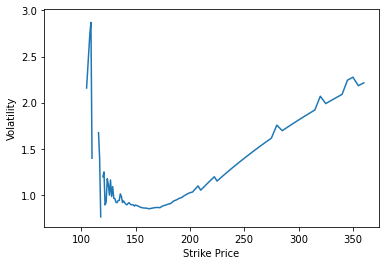

In [122]:
S = get_live_price(ticker)
r = 0.03

T = get_days_to_maturity(expiration_date_list[0]) / 252.0
print_volatility(calls, S, T, r)

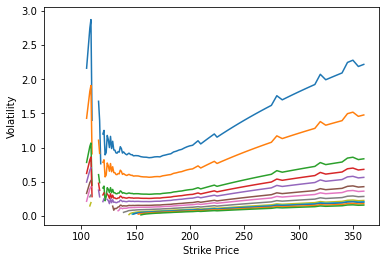

In [123]:
for expiration_date in expiration_date_list:
    T = get_days_to_maturity(expiration_date) / 252.0
    calls = options_dic[expiration_date]['calls']
    
    print_volatility(calls, S, T, r)